# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

## Cargar librerías

In [210]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pickle
import time
import squarify
from matplotlib import cm, colors

## Lectura de datos
- diabetic_data.csv
- admission_source_id.csv
- admission_type_id.csv
- discharge_disposition_id.csv

In [3]:
admin_src_df = pd.read_csv('data/admission_source_id.csv', 
                           na_values=["Not Available","None","Unknown/Invalid","Not Mapped"])
admin_type_df = pd.read_csv('data/admission_type_id.csv',
                           na_values = ["Not Available","None","Not Mapped"])
diabetic_df = pd.read_csv('data/diabetic_data.csv',
                          na_values=["Not Available","None","Unknown/Invalid","Not Mapped","?"])
dschrge_disp_df = pd.read_csv('data/discharge_disposition_id.csv',
                             na_values=["Not Available","None","Unknown/Invalid","Not Mapped"])
#id_mapping_df = pd.read_csv('data/IDs_mapping.csv')    #Es la colección de todas las demás tabals de referencia

C:\Users\bdih7\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
diabetic_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### comprobar correcta lectura de los datos
Revisemos qué hay en cada uno de los dataframes

In [5]:
#admin_src_df
#admin_type_df
dschrge_disp_df
#diabetic_df.head()

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpa...
5,6,Discharged/transferred to home with home healt...
6,7,Left AMA
7,8,Discharged/transferred to home under care of H...
8,9,Admitted as an inpatient to this hospital
9,10,Neonate discharged to another hospital for neo...


Dado que el método para importar funcionó bien, creemos una función para importar los datos que usaremos luego en nuestro _pipeline_

In [6]:
#Cargar el dataset
def load_df(path):
    df = pd.read_csv(path,
                     na_values=["Not Available","None","Unknown/Invalid","Not Mapped","?"])
    return(df)


Asignemos los índices originales a los ficheros de las tabals de referencia para desnormalizar la tabla _diabetic_ _ _df_

In [7]:
admin_src_df.set_index("admission_source_id", inplace = True)
admin_type_df.set_index("admission_type_id", inplace = True)
dschrge_disp_df.set_index("discharge_disposition_id", inplace = True)

Cambiemos el nombre de las descripciones de las tablas de referencia

In [8]:
admin_src_df.rename(columns={"description":"admin_src_desc"}, inplace = True)
admin_type_df.rename(columns={"description":"admin_type_desc"}, inplace = True)
dschrge_disp_df.rename(columns={"description":"dschrge_disp_desc"}, inplace = True)

### juntar todos los datos en el mismo DataFrame

Ahora sí ejecutemos los joins. Verifiquemos que si las relaciones son en efecto uno a uno

In [9]:
print(diabetic_df.join(admin_src_df,how="left", on = "admission_source_id").shape)
print(diabetic_df.join(admin_type_df,how="left", on = "admission_type_id").shape)
print(diabetic_df.join(dschrge_disp_df,how="left", on = "discharge_disposition_id").shape)
print(diabetic_df.shape)

(101766, 51)
(101766, 51)
(101766, 51)
(101766, 50)


In [10]:
aug_diabetic_df = diabetic_df.join(admin_src_df,how="left", on="admission_source_id")
aug_diabetic_df = aug_diabetic_df.join(admin_type_df,how="left", on = "admission_type_id")
aug_diabetic_df = aug_diabetic_df.join(dschrge_disp_df,how="left", on = "discharge_disposition_id")

Quitemos los id's que ya denormalizamos

In [11]:
aug_diabetic_df.drop(labels = ["admission_type_id","discharge_disposition_id","admission_source_id"], 
                     axis = 1, 
                     inplace = True)

In [12]:
aug_diabetic_df

,encounter_id,patient_nbr,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admin_src_desc,admin_type_desc,dschrge_disp_desc
0,2278392,8222157,Caucasian,Female,[0-10),NaN,1,NaN,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,NO,Physician Referral,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),NaN,3,NaN,NaN,59,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,2,NaN,NaN,11,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),NaN,2,NaN,NaN,44,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,NaN,NaN,51,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
5,35754,82637451,Caucasian,Male,[50-60),NaN,3,NaN,NaN,31,...,No,No,No,No,No,Yes,>30,Clinic Referral,Urgent,Discharged to home
6,55842,84259809,Caucasian,Male,[60-70),NaN,4,NaN,NaN,70,...,No,No,No,No,Ch,Yes,NO,Clinic Referral,Elective,Discharged to home
7,63768,114882984,Caucasian,Male,[70-80),NaN,5,NaN,NaN,73,...,No,No,No,No,No,Yes,>30,Emergency Room,Emergency,Discharged to home
8,12522,48330783,Caucasian,Female,[80-90),NaN,13,NaN,NaN,68,...,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Urgent,Discharged to home
9,15738,63555939,Caucasian,Female,[90-100),NaN,12,NaN,InternalMedicine,33,...,No,No,No,No,Ch,Yes,NO,Transfer from a hospital,Elective,Discharged/transferred to SNF


Ahora entendamos la información que tenemos en el _dataset_

In [13]:
aug_diabetic_df.set_index(["patient_nbr","encounter_id"], inplace = True)

De nuevo, creemos una función para aumentar el dataset con a través de _joins_ con las otras tablas

In [14]:
#Unir el dataset con las tablas de referencia
def augment_df(df,admin_src_df,admin_type_df,dschrge_disp_df):
    aug_df = df.copy()
    
    #Ejecutar los joins
    aug_df = aug_df.join(admin_src_df,how="left", on="admission_source_id")
    aug_df = aug_df.join(admin_type_df,how="left", on = "admission_type_id")
    aug_df = aug_df.join(dschrge_disp_df,how="left", on = "discharge_disposition_id")
    
    #Fijar los indices
    aug_df.set_index(["patient_nbr","encounter_id"], inplace = True)
    
    #Quitar los id's
    aug_df.drop(labels = ["admission_type_id","discharge_disposition_id","admission_source_id"],
                axis = 1, 
                inplace = True)
        
    return(aug_df)

## Data Wrangling

### Cambiar los nombres de las columnas para que cumplan buenas prácticas


In [15]:
aug_diabetic_df.columns = aug_diabetic_df.columns.str.lower().str.strip(' ').str.replace(pat="-",repl="_")

In [16]:
aug_diabetic_df.rename(columns={"diabetesmed":"diabetes_med","a1cresult":"a1c_result"},inplace=True)

Función para cambiar los nombres

In [17]:
#Ajustar los nomnbres de las variables de acuerdo al estándar definido
def ajustar_nombre_cols(df):
    df.columns = df.columns.str.lower().str.strip(' ').str.replace(pat="-",repl="_")
    df.rename(columns={"diabetesmed":"diabetes_med","a1cresult":"a1c_result"},inplace=True)
    return df

### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

Basados en el value_count(), convertiremos las siguientes variables a categorías ordenadas. No lo aplicamos a todos los valores enteros ya que algunos de ellos tienen muchos valores

In [18]:
#ordered_categories = ["num_procedures","time_in_hospital","number_inpatient","number_diagnoses"]
#aug_diabetic_df[ordered_categories] = aug_diabetic_df[ordered_categories].apply(lambda x: pd.Categorical(x.values, ordered = True))

Convirtamos ahora las variables codificadas como objetos restantes a categóricas 

In [19]:
aug_diabetic_df[aug_diabetic_df.select_dtypes("object").columns] = \
aug_diabetic_df[aug_diabetic_df.select_dtypes("object").columns].apply(lambda x: x.astype("category"))

In [20]:
#Typecasting de las variables categoricas
def typecasting_cats(df):
    df[df.select_dtypes("object").columns] = df[df.select_dtypes("object").columns].apply(lambda x: x.astype("category"))
    return(df)

### Tratamiento de Outliers

Debido al comportamiento de algunos de estas vriables numéricas, prerferimos codifcarlas como categóricas

In [21]:
## Número de visitas ambulatorias en el último año. Definimos rangos
number_outpat = []
for i in aug_diabetic_df.number_outpatient:
    if (i == 0):
        number_outpat.append("0")
    elif (i <= 2):
        number_outpat.append("1_2")
    elif (i <= 4):
        number_outpat.append("3_4")
    else:
        number_outpat.append("5_more")

aug_diabetic_df.number_outpatient = number_outpat
del(number_outpat)
aug_diabetic_df.number_outpatient.value_counts()

0         85027
1_2       12141
3_4        3141
5_more     1457
Name: number_outpatient, dtype: int64

In [22]:
## Visitas de emergencia en el último año (anterior al encuentro)
number_emergency = []
for i in aug_diabetic_df.number_emergency:
    if (i == 0):
        number_emergency.append("0")
    elif (i <= 2):
        number_emergency.append("1_2")
    else:
        number_emergency.append("3_more")

aug_diabetic_df.number_emergency = number_emergency
del(number_emergency)
aug_diabetic_df.number_emergency.value_counts()


0         90383
1_2        9719
3_more     1664
Name: number_emergency, dtype: int64

In [23]:
# Número de visitas 
aug_diabetic_df.number_inpatient.value_counts()

number_inpat = []
for i in aug_diabetic_df.number_inpatient:
    if (i == 0):
        number_inpat.append("0")
    elif (i <= 1):
        number_inpat.append("1")
    else:
        number_inpat.append("2_more")

aug_diabetic_df.number_inpatient = number_inpat
del(number_inpat)
aug_diabetic_df.number_inpatient.value_counts()

0         67630
1         19521
2_more    14615
Name: number_inpatient, dtype: int64

Con esto vemos que las categorías no están tan desbalanceadas. Creemos de nuevo la función para agregar a nuestro _pipeline_

In [24]:
#Tratar los outliers de ciertas columnas
def outlier_treatment_to_cat(df):
    #Variables que se van a recodificar a través de las siguientes listas
    number_outpat = []
    number_emergency = []
    number_inpat = []
    
    #Número de citas que tuvo sin ser hospitalizado o number_outpat
    for i in df.number_outpatient:
        if (i == 0):
            number_outpat.append("0")
        elif (i <= 2):
            number_outpat.append("1_2")
        elif (i <= 4):
            number_outpat.append("3_4")
        else:
            number_outpat.append("5_more")

    df.number_outpatient = number_outpat
    
    #Número de veces que fue al hospital por emergencias
    for i in df.number_emergency:
        if (i == 0):
            number_emergency.append("0")
        elif (i <= 2):
            number_emergency.append("1_2")
        else:
            number_emergency.append("3_more")

    df.number_emergency = number_emergency
    
    #Número de veces que fue hospitalizado por lo menos una noche
    for i in df.number_inpatient:
        if (i == 0):
            number_inpat.append("0")
        elif (i <= 1):
            number_inpat.append("1")
        else:
            number_inpat.append("2_more")

    df.number_inpatient = number_inpat

    return(df)

Para las variables que definitivamente vamos a dejar como numéricas, les haremos _capping_ asumiendo que se distribuyen normal a través de las siguientes funciones. Como este es un preprocesamiento dependiente de los datos, creamos una función _fit_ para obtener los límites del _capping_ desde el _train set_, así como una función transform para aplicar dichos límites

In [25]:
#Funciones para encontrar outliers y ajustarlos
def fit_outliers(df, num_std = 2.96):
    lim_sup = []
    columnas_outliers = df.select_dtypes(include=['float64', 'int64']).columns
    for element in columnas_outliers:
        std = df[element].std()
        mean = df[element].mean()
        lim_sup.append(int(round(mean + num_std * std)))
    
    return columnas_outliers, lim_sup

#Ajustarlos
def transform_outliers(df, cols, lim_sup):
    j = 0
    df2 = df.copy()
    for element in cols:
        df2[element] = [min(x, lim_sup[j]) for x in df[element]]
        j+=1
    return df2


### Verifiquemos valores nulos de variables importantes

Antes de revisar valores nulos mal codificados, verifiquemos el total de valores nulos ya identificados

In [26]:
aug_diabetic_df.isna().sum()/aug_diabetic_df.shape[0]

race                        0.022336
gender                      0.000029
age                         0.000000
weight                      0.968585
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.947468
a1c_result                  0.832773
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
glimepiride                 0.000000
acetohexamide               0.000000
glipizide                   0.000000
glyburide                   0.000000
t

Hasta el momento tenemos algunos _features_ con hasta 94 y 96% de valores nulos. En el caso del nivel de glucosa podríamos eliminarla, pero como es un _feature_ importante para este tipo de problema, el nivel máximo de glucosa, codifiquemos explícitamente el NA en las variables categóricas. En cuánto al peso, este falta por procedimientos administrativos del hospital, ya que muchos no estaba obligados a tenerlas registradas. Por esto eliminemos primero el peso

In [27]:
aug_diabetic_df.drop(["weight"], axis = 1, inplace = True)

In [28]:
#Quitar variables con un número muy alto de NA's especificado en el vector na_var_rm
def na_vars_rm(df,na_var_vec):
    df.drop(na_var_vec, axis = 1, inplace = True)
    return(df)

Ahora escojamos las variables a las que les cambiaremos sus NA por la categoría "faltante"

In [29]:
na_cat_cols = aug_diabetic_df.select_dtypes(exclude=np.number).columns[aug_diabetic_df.select_dtypes(exclude=np.number).isna().sum() > 0]

In [30]:
aug_diabetic_df_imp = aug_diabetic_df.copy()
aug_diabetic_df_imp[na_cat_cols] = aug_diabetic_df_imp[na_cat_cols].apply(lambda x: x.cat.set_categories(list(x.dropna().unique()) + ["Faltante"]))
aug_diabetic_df_imp[na_cat_cols] = aug_diabetic_df_imp[na_cat_cols].fillna("Faltante")

Dado que las variables numéricas no tienen outliers, por el momento podemos considerar que hemos terminado con nuestra imputación

In [31]:
aug_diabetic_df_imp.isna().sum()/aug_diabetic_df.shape[0]

race                        0.0
gender                      0.0
age                         0.0
time_in_hospital            0.0
payer_code                  0.0
medical_specialty           0.0
num_lab_procedures          0.0
num_procedures              0.0
num_medications             0.0
number_outpatient           0.0
number_emergency            0.0
number_inpatient            0.0
diag_1                      0.0
diag_2                      0.0
diag_3                      0.0
number_diagnoses            0.0
max_glu_serum               0.0
a1c_result                  0.0
metformin                   0.0
repaglinide                 0.0
nateglinide                 0.0
chlorpropamide              0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglitazone                0.0
rosiglitazone               0.0
acarbose                    0.0
miglitol                    0.0
troglita

Creemos la función para imputar las variables categóricas codificando de forma explícita los valores faltantes

In [32]:
#Imputar las variables categorícas de forma explícita con la categoría "Faltante"
def imputar_categoricas(df):
    #Lista de variables categoricas con NA
    na_cat_cols = df.select_dtypes(exclude=np.number).columns[df.select_dtypes(exclude=np.number).isna().sum() > 0]
    #Agregar la categoría faltante a las variables categóricas
    df[na_cat_cols] = df[na_cat_cols].apply(lambda x: x.cat.set_categories(list(x.dropna().unique()) + ["Faltante"]))
    #Imputar los valores faltantes con la categoría "Faltante"
    df[na_cat_cols] = df[na_cat_cols].fillna("Faltante")

    return(df)


### Quitemos las variables con baja varianza

In [33]:
pandas_profiling.ProfileReport(aug_diabetic_df_imp)

Number of variables,49
Number of observations,101766
Total Missing (%),0.0%
Total size in memory,11.9 MiB
Average record size in memory,123.1 B
Numeric,7
Categorical,40
Boolean,0
Date,0
Text (Unique),0
Rejected,2


Las siguientes variables tienen una varianza muy muy baja:
   
   * acetohexamide
   * citoglipton
   * examide
   * glimepiride_pioglitazone
   * metformin_pioglitazone
   * metformin_rosiglitazone

   
Quitemos estas variables

In [34]:
low_var_rm = ["acetohexamide","citoglipton","examide","glimepiride_pioglitazone","metformin_pioglitazone","metformin_rosiglitazone","troglitazone"]
aug_diabetic_df_imp.drop(low_var_rm, axis = 1, inplace = True)

In [35]:
#Quitar variables con muy baja varianza especificada en el vector low_var_rm
def low_vars_rm(df,low_var_vec):
    df.drop(low_var_vec, axis = 1, inplace = True)
    return(df)

Variables con muy alta variabilidad son:

* diag_1
* diag_2
* diag_3

Podría reducirse el número de categorías (>700) con el conocimiento de un experto

In [36]:
#high_var_rm = ["payer_code"]
#aug_diabetic_df_imp.drop(high_var_rm, axis = 1, inplace = True)

In [37]:
#Quitar variables con varianza muy muy alta especificada en el vector high_var_rm
#def high_vars_rm(df,high_var_vec):
#    df.drop(high_var_vec, axis = 1, inplace = True)
#    return(df)

Variables numéricas candidatas a ser categóricas binarias:
* number_emergency
* number_outpatient
 

### Encoding para realizar la agregación

In [38]:
oh_diab_df = aug_diabetic_df_imp.copy()

In [39]:
#oh_encoder = OneHotEncoder(handle_unknown="ignore")
l_bin_dict = defaultdict(LabelBinarizer)
oh_diab_df.select_dtypes(exclude=np.number).drop("readmitted",axis=1).apply(lambda x: l_bin_dict[x.name].fit(x))

race                   LabelBinarizer(neg_label=0, pos_label=1, spars...
gender                 LabelBinarizer(neg_label=0, pos_label=1, spars...
age                    LabelBinarizer(neg_label=0, pos_label=1, spars...
payer_code             LabelBinarizer(neg_label=0, pos_label=1, spars...
medical_specialty      LabelBinarizer(neg_label=0, pos_label=1, spars...
number_outpatient      LabelBinarizer(neg_label=0, pos_label=1, spars...
number_emergency       LabelBinarizer(neg_label=0, pos_label=1, spars...
number_inpatient       LabelBinarizer(neg_label=0, pos_label=1, spars...
diag_1                 LabelBinarizer(neg_label=0, pos_label=1, spars...
diag_2                 LabelBinarizer(neg_label=0, pos_label=1, spars...
diag_3                 LabelBinarizer(neg_label=0, pos_label=1, spars...
max_glu_serum          LabelBinarizer(neg_label=0, pos_label=1, spars...
a1c_result             LabelBinarizer(neg_label=0, pos_label=1, spars...
metformin              LabelBinarizer(neg_label=0, 

In [40]:
#Crear el diccionario de binarizers para hacer el one-hot encoding
def crear_diccionario_binarizer(df):
    l_bin_dict = defaultdict(LabelBinarizer)
    binarizer_dict = df.select_dtypes(exclude=np.number).apply(lambda x: l_bin_dict[x.name].fit(x))
    return binarizer_dict

#Función para ejecutar el label binarizer y agregarlo al dataframe original
def one_hot_encoder(df, binarizer_dict):
    for feature_name, binarizer in binarizer_dict.items():
        if(binarizer.classes_.shape[0] == 2):
            df[feature_name + "_" + list(binarizer.classes_)[0]] = binarizer.transform(df[feature_name]) 
        
        else:
            tmp_df = pd.DataFrame(binarizer.transform(df[feature_name]), columns=[feature_name + "_" + s for s in list(binarizer.classes_)], index = df.index)
            df = pd.concat([df , tmp_df], axis = 1)
    
    return df

In [41]:
one_hot_encoder(oh_diab_df,l_bin_dict)

,,race,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,dschrge_disp_desc_Discharged/transferred/referred to this institution for outpatient services,dschrge_disp_desc_Expired,"dschrge_disp_desc_Expired at home. Medicaid only, hospice.","dschrge_disp_desc_Expired in a medical facility. Medicaid only, hospice.",dschrge_disp_desc_Faltante,dschrge_disp_desc_Hospice / home,dschrge_disp_desc_Hospice / medical facility,dschrge_disp_desc_Left AMA,dschrge_disp_desc_Neonate discharged to another hospital for neonatal aftercare,dschrge_disp_desc_Still patient or expected to return for outpatient services
patient_nbr,encounter_id,,,,,,,,,,,,,,,,,,,,,
8222157,2278392,Caucasian,Female,[0-10),1,Faltante,Pediatrics-Endocrinology,41,0,1,0,...,0,0,0,0,1,0,0,0,0,0
55629189,149190,Caucasian,Female,[10-20),3,Faltante,Faltante,59,0,18,0,...,0,0,0,0,0,0,0,0,0,0
86047875,64410,AfricanAmerican,Female,[20-30),2,Faltante,Faltante,11,5,13,1_2,...,0,0,0,0,0,0,0,0,0,0
82442376,500364,Caucasian,Male,[30-40),2,Faltante,Faltante,44,1,16,0,...,0,0,0,0,0,0,0,0,0,0
42519267,16680,Caucasian,Male,[40-50),1,Faltante,Faltante,51,0,8,0,...,0,0,0,0,0,0,0,0,0,0
82637451,35754,Caucasian,Male,[50-60),3,Faltante,Faltante,31,6,16,0,...,0,0,0,0,0,0,0,0,0,0
84259809,55842,Caucasian,Male,[60-70),4,Faltante,Faltante,70,1,21,0,...,0,0,0,0,0,0,0,0,0,0
114882984,63768,Caucasian,Male,[70-80),5,Faltante,Faltante,73,0,12,0,...,0,0,0,0,0,0,0,0,0,0
48330783,12522,Caucasian,Female,[80-90),13,Faltante,Faltante,68,2,28,0,...,0,0,0,0,0,0,0,0,0,0


# Pipeline de preprocesamiento

Ya con el preprocesamiento definido, definamos un pipeline para preprocesar los datos. Hay algunos pasos que nos fatlan como recodificar la variable objetivo

In [42]:
#Recodificar la variable objetivo
def recode_target(df):
    recode = []
    for i in df.readmitted:
        if (i == ">30"):
            recode.append("YES")
        elif (i == "<30"):
            recode.append("YES")
        else:
            recode.append("NO")

    df.readmitted = recode
    
    return df

Igualmente, nos hace falta una función para realizar el split entre train y validación

In [43]:
def cargar_y_split(path):
    #cargar el dataset
    df = load_df(path=path)
    
    #Codificar variable objetivo
    df = recode_target(df)
    
    #realizar split train
    x_train, x_test, y_train, y_test = train_test_split(df.drop("readmitted",axis=1),
                                                        df.readmitted, 
                                                        random_state = 123, 
                                                        stratify = df.readmitted, 
                                                        test_size = 0.3)
    
    return x_train, x_test, y_train, y_test
    

Ya con estas funciones, podemos crear cómodamente nuestro pipeline tanto para _train_ como para validación

In [44]:
def pipeline_train(df,admin_src_df,admin_type_df,dschrge_disp_df,low_var_vec,na_var_vec):

    #Enrriquecer el dataset
    df = augment_df(df,admin_src_df,admin_type_df,dschrge_disp_df)
    
    #Ajustar nombres
    df = ajustar_nombre_cols(df)
    
    #Tratar outliers pasando las variables a categóricas
    df = outlier_treatment_to_cat(df)
    
    #Encontrar features para hacerles capping
    columnas_outliers, lim_sup = fit_outliers(df)
    
    #Ejecutar el capping sobre estos features definidos en columnas_outliers
    df = transform_outliers(df, cols = columnas_outliers, lim_sup=lim_sup)
    
    #Typecasting
    df = typecasting_cats(df)
        
    #Quitar variables de baja varianza
    df = low_vars_rm(df,low_var_vec)
    
    #Quitar variables de alta varianza
    #df = high_vars_rm(df,high_var_vec)
    
    #Quitar variables con un número alto de NA's
    df = na_vars_rm(df,na_var_vec)
    
    #Codificar explícitamente los NA's
    df = imputar_categoricas(df)
    
    #Crear diccionario binarizer
    binarizer_dict = crear_diccionario_binarizer(df)
    
    #Realizar one-hot encoding
    df_oh = one_hot_encoder(df, binarizer_dict)
    
    return df_oh, df, columnas_outliers, lim_sup, binarizer_dict

Noten que la función de preprocesamiento del train devuelve no solo el dataframe, sino los objetos con los que se realizará el preprocesamiento dependiente de los datos sobre el set de validación, y posteriormente el de _test_.

In [45]:
def pipeline_test(df,admin_src_df, admin_type_df, dschrge_disp_df, low_var_vec,\
                  na_var_vec, columnas_outliers, lim_sup_outliers, binarizer_dict):

    #Enrriquecer el dataset
    df = augment_df(df,admin_src_df,admin_type_df,dschrge_disp_df)
    
    #Ajustar nombres
    df = ajustar_nombre_cols(df)
    
    #Tratar outliers pasando las variables a categóricas
    df = outlier_treatment_to_cat(df)
    
    #Ejecutar el capping sobre estos features definidos en columnas_outliers
    df = transform_outliers(df, cols = columnas_outliers, lim_sup = lim_sup_outliers)
    
    #Typecasting
    df = typecasting_cats(df)
        
    #Quitar variables de baja varianza
    df = low_vars_rm(df,low_var_vec)
    
    #Quitar variables de alta varianza
    #df = high_vars_rm(df,high_var_vec)
    
    #Quitar variables con un número alto de NA's
    df = na_vars_rm(df,na_var_vec)
    
    #Codificar explícitamente los NA's
    df = imputar_categoricas(df)
    
    #Realizar one-hot encoding
    df_oh = one_hot_encoder(df, binarizer_dict)
    
    return df_oh, df

Ejecutemos entonces nuestro _pipeline_

In [46]:
low_var_rm = ["acetohexamide","citoglipton","examide","glimepiride_pioglitazone",\
              "metformin_pioglitazone","metformin_rosiglitazone","troglitazone"]
#high_var_rm = ["payer_code"]
na_var_rm = ["weight"]

In [47]:
x_train, x_test, y_train, y_test =  cargar_y_split("data/diabetic_data_ws.csv")

C:\Users\bdih7\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [48]:
x_train_pre_oh,x_train_pre,columnas_outliers, lim_sup_outliers, binarizer_dict = \
pipeline_train(x_train,admin_src_df,admin_type_df,dschrge_disp_df,low_var_rm,na_var_rm)

In [49]:
x_train_pre

,,race,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,miglitol,tolazamide,insulin,glyburide_metformin,glipizide_metformin,change,diabetes_med,admin_src_desc,admin_type_desc,dschrge_disp_desc
patient_nbr,encounter_id,,,,,,,,,,,,,,,,,,,,,
-5507571366342522588,231840588,Caucasian,Female,[40-50),3,DM,Faltante,53,6,16,0,...,No,No,Steady,No,No,No,Yes,Physician Referral,Elective,Discharged to home
-2121164979740686064,120204594,Caucasian,Female,[60-70),3,MC,Orthopedics,26,2,35,1_2,...,No,No,Up,No,No,Ch,Yes,Physician Referral,Elective,Discharged to home
6744321317740308718,79176972,AfricanAmerican,Female,[40-50),4,Faltante,InternalMedicine,67,0,16,0,...,No,No,Steady,No,No,Ch,Yes,Emergency Room,Emergency,Discharged to home
8769627295344250645,150725256,Caucasian,Male,[70-80),2,MC,Faltante,57,0,17,0,...,No,No,Steady,No,No,Ch,Yes,Physician Referral,Faltante,Discharged/transferred to home with home healt...
-661136200660237769,80165568,Caucasian,Male,[50-60),13,Faltante,Faltante,53,5,22,0,...,No,No,Steady,No,No,No,Yes,Emergency Room,Emergency,Discharged to home
8569064694212585723,176782398,Caucasian,Male,[30-40),5,BC,Faltante,75,2,25,0,...,No,No,Down,No,No,Ch,Yes,Emergency Room,Emergency,Discharged to home
-5971356033009238106,52491708,Hispanic,Male,[60-70),6,Faltante,InternalMedicine,67,1,8,0,...,No,No,No,No,No,Ch,Yes,Physician Referral,Emergency,Discharged/transferred to home with home healt...
-2200814024863824966,193027038,AfricanAmerican,Female,[60-70),7,MC,Cardiology,58,1,23,0,...,No,No,No,No,No,Ch,Yes,Emergency Room,Emergency,Discharged/transferred to home with home healt...
-5045355015718688786,122305074,Caucasian,Female,[50-60),2,UN,Faltante,67,0,6,0,...,No,No,Steady,No,No,No,Yes,Emergency Room,Emergency,Discharged to home


In [50]:
x_test_pre_oh,x_test_pre = pipeline_test(x_test,admin_src_df,admin_type_df,dschrge_disp_df,\
                                         low_var_rm,na_var_rm,columnas_outliers, lim_sup_outliers, \
                                         binarizer_dict )

# Modelamiento

Empecemos usando un RF para entender cuáles son los features más importantes del problema en relación con la variable objetivo

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,f1_score,accuracy_score, precision_score
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
import time
from sklearn import preprocessing
from keras.models import load_model
from sklearn.metrics import confusion_matrix

In [52]:
rf = RandomForestClassifier(n_estimators=100,max_depth=45,max_features="auto", min_samples_split=2,n_jobs=-1)

In [53]:
%%time
rf.fit(x_train_pre_oh.select_dtypes(include=np.number),y_train)

Wall time: 57.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=45, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
results_rf = pd.DataFrame()
results_rf["rf_pred"] = rf.predict(x_test_pre_oh.select_dtypes(include=np.number))
results_rf["y_true"] = y_test.values
print(accuracy_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true))
print(precision_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))
print(recall_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))
print(f1_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))

0.6473384403849931
0.6485821294810059
0.5156542453632806
0.5745295985591735


El modelo tiene un desempeño decente en comparación con otras opciones. Evaluemos ahora la importancia de las variables

In [55]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Veamos un listado de las variables importantes

In [56]:
# Print the feature ranking
print("Feature ranking:")
feature_names = x_train_pre_oh.select_dtypes(include=np.number).columns
for f in range(x_train_pre_oh.select_dtypes(include=np.number).shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], feature_names[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature 1: num_lab_procedures (0.038714)
2. feature 3: num_medications (0.037296)
3. feature 115: number_inpatient_0 (0.030000)
4. feature 0: time_in_hospital (0.028134)
5. feature 117: number_inpatient_2_more (0.027604)
6. feature 4: number_diagnoses (0.025607)
7. feature 2: num_procedures (0.020201)
8. feature 2291: dschrge_disp_desc_Expired (0.013349)
9. feature 116: number_inpatient_1 (0.010550)
10. feature 108: number_outpatient_0 (0.009993)
11. feature 112: number_emergency_0 (0.009942)
12. feature 2276: dschrge_disp_desc_Discharged to home (0.008536)
13. feature 13: gender_Male (0.008468)
14. feature 21: age_[70-80) (0.008435)
15. feature 12: gender_Female (0.008397)
16. feature 52: medical_specialty_Faltante (0.008357)
17. feature 29: payer_code_Faltante (0.008335)
18. feature 31: payer_code_MC (0.007933)
19. feature 20: age_[60-70) (0.007724)
20. feature 2253: admin_src_desc_ Emergency Room (0.007686)
21. feature 2250: change_Ch (0.007468)
22. feature 7: ra

1130. feature 2079: diag_3_999 (0.000027)
1131. feature 402: diag_1_457 (0.000027)
1132. feature 961: diag_2_335 (0.000027)
1133. feature 1764: diag_3_494 (0.000027)
1134. feature 1885: diag_3_664 (0.000027)
1135. feature 1783: diag_3_522 (0.000026)
1136. feature 1173: diag_2_611 (0.000026)
1137. feature 1300: diag_2_836 (0.000026)
1138. feature 406: diag_1_462 (0.000026)
1139. feature 1582: diag_3_266 (0.000026)
1140. feature 2080: diag_3_E812 (0.000026)
1141. feature 1826: diag_3_580 (0.000026)
1142. feature 1859: diag_3_621 (0.000026)
1143. feature 819: diag_2_174 (0.000026)
1144. feature 411: diag_1_47 (0.000026)
1145. feature 1079: diag_2_485 (0.000026)
1146. feature 1038: diag_2_431 (0.000026)
1147. feature 2120: diag_3_E930 (0.000026)
1148. feature 1974: diag_3_792 (0.000026)
1149. feature 283: diag_1_305 (0.000026)
1150. feature 1218: diag_2_706 (0.000025)
1151. feature 824: diag_2_191 (0.000025)
1152. feature 512: diag_1_594 (0.000025)
1153. feature 2233: acarbose_Up (0.000025

1629. feature 1406: diag_2_E929 (0.000008)
1630. feature 978: diag_2_351 (0.000008)
1631. feature 573: diag_1_685 (0.000008)
1632. feature 1478: diag_3_148 (0.000008)
1633. feature 155: diag_1_179 (0.000008)
1634. feature 237: diag_1_250.9 (0.000008)
1635. feature 1998: diag_3_826 (0.000008)
1636. feature 1754: diag_3_481 (0.000008)
1637. feature 1949: diag_3_75 (0.000008)
1638. feature 1505: diag_3_192 (0.000008)
1639. feature 198: diag_1_237 (0.000008)
1640. feature 149: diag_1_170 (0.000008)
1641. feature 1100: diag_2_517 (0.000008)
1642. feature 1748: diag_3_472 (0.000008)
1643. feature 2057: diag_3_933 (0.000008)
1644. feature 1798: diag_3_538 (0.000008)
1645. feature 1868: diag_3_643 (0.000008)
1646. feature 205: diag_1_245 (0.000008)
1647. feature 588: diag_1_708 (0.000008)
1648. feature 1375: diag_2_E816 (0.000008)
1649. feature 2128: diag_3_E938 (0.000008)
1650. feature 1653: diag_3_350 (0.000008)
1651. feature 1512: diag_3_201 (0.000008)
1652. feature 2085: diag_3_E819 (0.000

2129. feature 685: diag_1_846 (0.000001)
2130. feature 1750: diag_3_475 (0.000001)
2131. feature 1259: diag_2_759 (0.000001)
2132. feature 1439: diag_2_V23 (0.000001)
2133. feature 1376: diag_2_E818 (0.000001)
2134. feature 1452: diag_2_V60 (0.000001)
2135. feature 1256: diag_2_755 (0.000001)
2136. feature 1467: diag_3_122 (0.000001)
2137. feature 192: diag_1_229 (0.000001)
2138. feature 1877: diag_3_655 (0.000001)
2139. feature 555: diag_1_655 (0.000001)
2140. feature 2101: diag_3_E882 (0.000001)
2141. feature 1907: diag_3_702 (0.000001)
2142. feature 1377: diag_2_E819 (0.000001)
2143. feature 2064: diag_3_953 (0.000001)
2144. feature 419: diag_1_48 (0.000001)
2145. feature 973: diag_2_347 (0.000001)
2146. feature 1355: diag_2_962 (0.000001)
2147. feature 548: diag_1_645 (0.000001)
2148. feature 1390: diag_2_E882 (0.000001)
2149. feature 1187: diag_2_641 (0.000001)
2150. feature 761: diag_1_976 (0.000001)
2151. feature 542: diag_1_634 (0.000001)
2152. feature 563: diag_1_663 (0.000001

Visualicemos la importancia de las variables

In [144]:
feature_names = list(x_train_pre_oh.select_dtypes(include=np.number).columns)

In [95]:
importances_filter = importances[importances > 1e-4]
feature_names_filter = feature_names[:importances_filter.shape[0]]
importances_filter = [0:40]

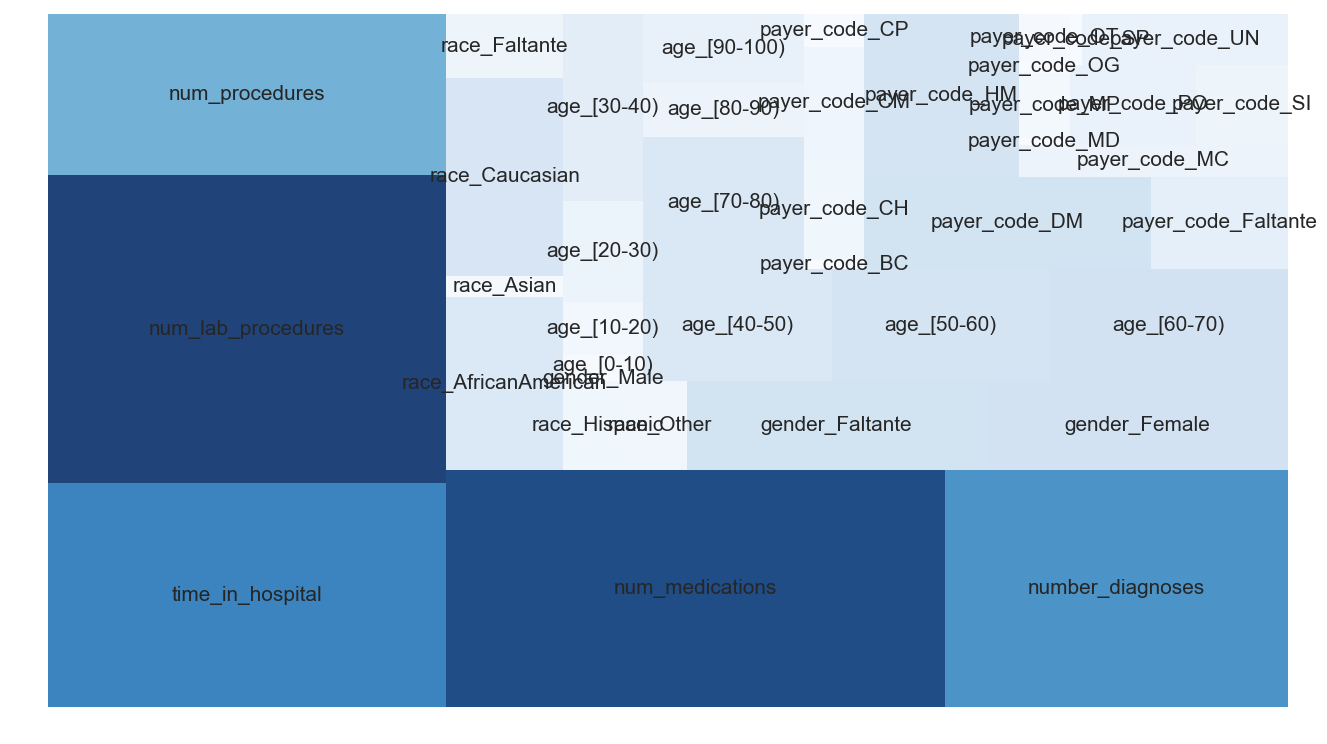

In [118]:
plt.rcParams["figure.figsize"] = [16,9]

num_features = 40
importances_filter_2 = importances_filter[:num_features]
feature_names_filter_2 = feature_names_filter[:num_features]

#Escala de colores
cmap = cm.Blues
mini=min(importances_filter_2)
maxi=max(importances_filter_2)
norm = colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in importances_filter_2]

#Plotear
plt.rc('font', size= 15)  
squarify.plot(sizes=importances_filter_2, label=feature_names_filter_2, color=colors, alpha=.9)
#plt.set_xticks([])
#plt.set_yticks([])
plt.axis('off')
plt.show()

De acuerdo a lo que vemos en la gráfica, las variables más importantes son las que están directamente relacionadas con el tratamiento médico, como el número de procedimientos, exámenes de laboratorio, medicamentos y diagnósticos.

En segundo lugar pesan más las edades, siendo los segmentos 50 en adelante los más importantes. A partir de este punto los más importante son las razas, seguido por el método usado por la persona para pagar. 

Para un modelado más ágil, a partir de este punto usaremos solo los features que tengan al menos dos órdenes de magnitud menos de importancia que la variable más importante  

In [145]:
imp_feature_list = x_train_pre_oh.select_dtypes(include=np.number).columns[indices[1:185]]

In [62]:
#Guardar la lista de variables más importantes
with open('imp_feature_list', 'wb') as f:
    pickle.dump(imp_feature_list, f)

## Modelamiento con una red neuronal

Filtramos el dataset original con el conjunto de variables con el que vamos a modelar

In [186]:
with open('./pickle_files/imp_feature_list', 'rb') as f:
    final_vars = pickle.load(f)

In [161]:
## Filtramos el dataset con dichas variables
x_train_nn = x_train_pre_oh[final_vars]
print(x_train_nn.shape)

x_test_nn = x_test_pre_oh[final_vars]
print(x_test_nn.shape)

(59392, 184)
(25455, 184)


In [176]:
def filtrar_vars_importantes(df_train,df_test,important_vars):
    df_train = df_train[important_vars]
    df_test = df_test[important_vars]
    
    return df_train, df_test

Preprocesamiento para entrenar la red

In [162]:
## Aplicamos to_categorical
target_train = to_categorical([1 if x is 'YES' else 0 for x in y_train ])
x_train_nn = x_train_nn.select_dtypes(include=np.number)

## Escaldo de los datos
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(x_train_nn)
x_train_nn = min_max_scaler.transform(x_train_nn)
print("train shape:", x_train_nn.shape)

## Datos de test
target_test = to_categorical([1 if x is 'YES' else 0 for x in y_test])

## Tamaño del dataset
x_test_nn = x_test_nn.select_dtypes(include=np.number)

## min max scaler
x_test_nn = min_max_scaler.transform(x_test_nn)
print('test shape:', x_test_nn.shape)

train shape: (59392, 184)
test shape: (25455, 184)


In [178]:
def typecasting_ann(df_train,df_test,target_train,target_test):
    #Escoger solo las variables numéricas del set de features
    df_train = df_train.select_dtypes(include=np.number)
    df_test = df_test.select_dtypes(include=np.number)
    
    #Cambiar las variables objetivo de train y validación a categorico
    target_train = to_categorical([1 if x is 'YES' else 0 for x in target_train])
    target_test = to_categorical([1 if x is 'YES' else 0 for x in target_test])
    
    return df_train,df_test,target_train,target_test

In [187]:
def escalar_datos(df_train,df_test):
    #Ajustar el scaler
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit(df_train)
    
    #Aplicarlo sobre los datasets
    df_train = min_max_scaler.transform(df_train)
    df_test = min_max_scaler.transform(df_test)
    
    return df_train,df_test

#### Agrueguemos un paso más a nuestro pipeline

In [188]:
def pipe_line_ann(df_train,df_test,target_train,target_test,important_vars):
    
    df_train,df_test = filtrar_vars_importantes(df_train,df_test,important_vars)
    
    df_train,df_test,target_train,target_test = typecasting_ann(df_train,df_test,target_train,target_test)
    
    df_train,df_test = escalar_datos(df_train,df_test)
    
    return df_train,df_test,target_train,target_test

Apliquemos el pipeline a nuestros datos

In [189]:
x_train_nn, x_test_nn,target_train,target_test = pipe_line_ann(x_train_pre_oh,x_test_pre_oh,y_train,y_test,final_vars)

#### Ahora sí probemos nuestro modelo

Carguemos la arquitectura del modelo que mejor desempeño tuvo

In [163]:
nnet_model = model = load_model('./arch_models/nnet_075.h5')
nnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_95 (Dropout)         (None, 184)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 128)               23680     
_________________________________________________________________
dropout_96 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_122 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_97 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_98 (Dropout)         (None, 128)               0         
__________

Ahora obtengamos las predicciones del modelo

In [199]:
predicciones = nnet_model.predict(x_test_nn)

pred = pd.Series([np.argmax(x) for x in predicciones], name='Pred')
prob = pd.Series([x[1] for x in predicciones], name='Prob')
real = pd.Series([np.argmax(x) for x in target_test], name='real')

resultados = pd.concat([pred, prob, real], axis=1)
resultados.head()

,Pred,Prob,real
0,1,0.635493,1
1,1,0.666239,1
2,1,0.511726,0
3,0,0.458879,0
4,0,0.421592,1


In [201]:
## umbral de 0.48
umbral = 0.48
pred = pd.Series([1 if x>=umbral else 0 for x in prob], name='Pred')

Evaluemos las métricas

In [202]:
accuracy = accuracy_score(real, pred)
precision = precision_score(real, pred)
recall = recall_score(real, pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("recall:", recall)


Accuracy: 0.6225495973286191
Precision: 0.5639833035181873
recall: 0.8046622426408031


Vizualicemos la matriz de confusión 

Test accuracy: 63.43%


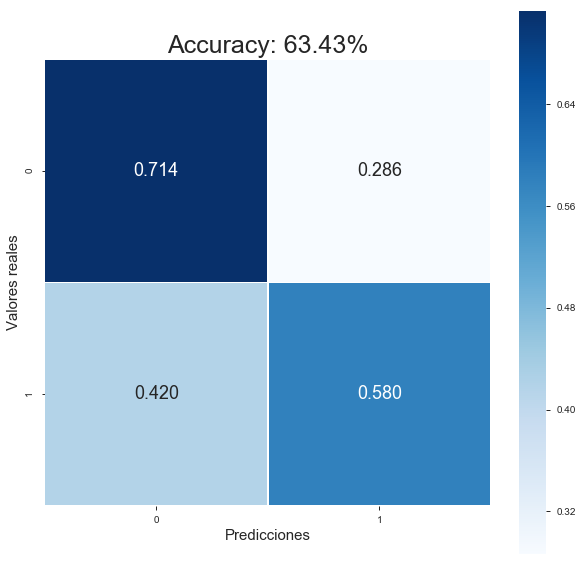

In [175]:
## Accuracy
test_acc = accuracy_score(resultados.real, resultados.Pred)
print('Test accuracy: {:1.2%}'.format(test_acc))

#print(real.value_counts())
cm = confusion_matrix(pred, real)
cm_nor = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.rc('font', size= 18) 
plt.figure(figsize=(10,10))
sns.heatmap(cm_nor, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
plt.ylabel('Valores reales', size = 15);
plt.xlabel('Predicciones', size = 15);
all_sample_title = 'Accuracy: {:1.2%}'.format(test_acc) 
plt.title(all_sample_title, size = 25);

# HASTA AQUÍ, EL RESTO ESTÁ SIN TERMINAR

## EDA con base en la importancia de las variables

#### Variables directamente relacionadas con el tratamiento

In [135]:
plot_df = x_train_pre.copy()
plot_df["readmitted"] = y_train

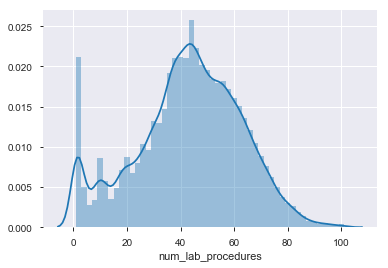

In [216]:
sns.distplot(xplot_df.num_lab_procedures)#, y="readmitted", kind="kde",data=plot_df);

In [218]:
g = sns.FacetGrid(plot_df, col="readmitted", margin_titles=True)
g.map(sns.distplot, a = plot_df.num_lab_procedures, color="steelblue")

#### Tunning del Random Forest

In [75]:
rf = RandomForestClassifier(n_jobs=-1)

In [90]:
grid_rf = {
    "n_estimators":[100],
    "max_depth":[57],
    "min_samples_split":[2],
    "max_features":[100,120],
}

grid_rf_cv = GridSearchCV(rf, grid_rf)

In [91]:
%%time
grid_rf_cv.fit(x_train_pre_oh.select_dtypes(include=np.number),y_train)

Wall time: 11min 3s


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_depth': [57], 'min_samples_split': [2], 'max_features': [100, 120, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [92]:
results_rf = pd.DataFrame()
results_rf["rf_pred"] = grid_rf_cv.best_estimator_.predict(x_test_pre_oh.select_dtypes(include=np.number))
results_rf["y_true"] = y_test.values
print(accuracy_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true))
print(precision_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))
print(recall_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))
print(f1_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))

0.648831270870163
0.6412443552433518
0.5436447166921899
0.5884248814402138


In [93]:
grid_rf_cv.best_params_

{'max_depth': 57,
 'max_features': 150,
 'min_samples_split': 2,
 'n_estimators': 100}

In [88]:
best_rf = grid_rf_cv.best_estimator_

In [73]:

rf2 = RandomForestClassifier(n_estimators=200,max_depth=45,max_features=15, min_samples_split=2,n_jobs=-1)

In [74]:
%%time
rf2.fit(x_train_pre_oh.select_dtypes(include=np.number).iloc[:,indices[1:185]],y_train)

Wall time: 2min 11s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=45, max_features=80, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
results_rf = pd.DataFrame()
results_rf["rf_pred"] = rf2.predict(x_test_pre_oh.select_dtypes(include=np.number).iloc[:,indices[1:185]])
results_rf["y_true"] = y_test.values
print(accuracy_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true))
print(precision_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))
print(recall_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))
print(f1_score(y_pred = results_rf.rf_pred, y_true = results_rf.y_true,pos_label="YES"))

0.6398742879591436
0.624626649966278
0.5515569167942828
0.5858220756336693
